In [2]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math
import pandas as pd
from PIL import Image, ImageDraw
import seaborn as sns
rng = np.random.default_rng()


In [3]:
%%bash
slim -s 119 -d R0=10 bearded_seals.slim

// Initial random seed:
119

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'nonWF');
initializeSLiMOptions(keepPedigrees = T, dimensionality = 'xy');
initializeSex("A");
22026
initializeInteractionType(1, "xy", reciprocal=T, maxDistance=0.56419, sexSegregation="FM");
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 99999);
initializeMutationRate(0);
initializeRecombinationRate(1e-08);

// Starting run at tick <start>:
1 



In [4]:
parents = pd.read_csv("bearded_seal_parents.csv")

### Define a sampling intensity grid and sample from dead animals for each year according to the grid

In [5]:
# Divide into years
sample_year = 41
sample_parents = parents.loc[parents.sampling_time == sample_year]

In [6]:
def sample_cell(sample_parents, xmin, xmax, ymin, ymax, nmax):
    # Sample from individuals within one grid cell
    in_i = np.where(np.logical_and(np.logical_and(sample_parents.loc[:,'x'] <= xmax, sample_parents.loc[:,'x'] >= xmin),
                np.logical_and(sample_parents.loc[:,'y'] >= ymin, sample_parents.loc[:,'y'] <= ymax)))[0]
    # Sample size is nmax or the number of individuals in the area
    ss = min(len(in_i), nmax)
    sample_rows = rng.choice(in_i, ss, replace = False)
    return(ss, sample_rows)

In [8]:
def sample_grid(individuals, sampling_intensity, n, width = 10, height = 10):
    # Sample from each grid cell
    # Sample size 
    ss = np.array(np.ceil(n*sampling_intensity/np.sum(sampling_intensity)), dtype = int)
    # Keep track of actual sample sizes (since if there are fewer than ss individuals in a grid cell, all are sampled)
    realized_ss = np.zeros(ss.shape, dtype = int)
    
    # Width and height of grid cells
    x_cells = ss.shape[0]
    y_cells = ss.shape[1]
    dx = width/x_cells
    dy = height/y_cells
    
    # Keep track of sampled rows
    #sample_rows = np.empty(round(np.sum(ss)), dtype = int)
    sample_rows = np.empty(0, dtype = int)
    # Sample from each grid cell
    for ix, iy in np.ndindex(ss.shape):
        xmin = dx*ix
        xmax = dx*ix + dx
        ymin = dy*iy
        ymax = dy*iy + dy
        nmax = ss[ix, iy]
        realized_ss[ix, iy], grid_rows = sample_cell(individuals, xmin, xmax, ymin, ymax, nmax)
        sample_rows = np.concatenate([sample_rows, grid_rows])
    return(realized_ss, sample_rows)

In [10]:
sampling_intensity =  np.ones((10,10))*np.linspace(1, 2, 10)
print(sampling_intensity)
ss, sample_rows = sample_grid(parents, sampling_intensity, 1000, 10, 10)
print(ss)
sample = parents.iloc[sample_rows]

[[1.         1.11111111 1.22222222 1.33333333 1.44444444 1.55555556
  1.66666667 1.77777778 1.88888889 2.        ]
 [1.         1.11111111 1.22222222 1.33333333 1.44444444 1.55555556
  1.66666667 1.77777778 1.88888889 2.        ]
 [1.         1.11111111 1.22222222 1.33333333 1.44444444 1.55555556
  1.66666667 1.77777778 1.88888889 2.        ]
 [1.         1.11111111 1.22222222 1.33333333 1.44444444 1.55555556
  1.66666667 1.77777778 1.88888889 2.        ]
 [1.         1.11111111 1.22222222 1.33333333 1.44444444 1.55555556
  1.66666667 1.77777778 1.88888889 2.        ]
 [1.         1.11111111 1.22222222 1.33333333 1.44444444 1.55555556
  1.66666667 1.77777778 1.88888889 2.        ]
 [1.         1.11111111 1.22222222 1.33333333 1.44444444 1.55555556
  1.66666667 1.77777778 1.88888889 2.        ]
 [1.         1.11111111 1.22222222 1.33333333 1.44444444 1.55555556
  1.66666667 1.77777778 1.88888889 2.        ]
 [1.         1.11111111 1.22222222 1.33333333 1.44444444 1.55555556
  1.66666667

In [11]:
def make_spaghetti(sample_parents, max_width, max_height):
    # creating new Image object for spaghetti and sampling
    w, h = 500, 500
    spaghetti = Image.new("1", (w, h))
    sampling = Image.new("1", (w, h))
    img1 = ImageDraw.Draw(spaghetti)
    img2 = ImageDraw.Draw(sampling)

    # Find individuals with a parent that is in the sample
    p_in_i = np.isin(sample_parents.loc[:,'parent1'], sample_parents.loc[:,'individual'])
    npairs = sum(p_in_i)

    # Get location of parent-offspring pairs and plot
    children = sample_parents.loc[p_in_i, :]
    for child_i, child_row in children.iterrows():
        parent_i = np.where(sample_parents.loc[:,'individual'] == child_row['parent1'])[0][0]
        parent_row = sample_parents.iloc[parent_i,:]
        # print(parent_row['individual'], child_row['individual'])
        x_child, y_child = child_row[['x','y']]
        x_parent, y_parent = parent_row[['x','y']]
        img1.line([(x_child*w/max_width, y_child*h/max_height), (x_parent*w/max_width, y_parent*h/max_height)], fill ="white", width = 0)

    # Plot sampling
    for ind_i, ind_row in sample_parents.iterrows():
        x, y = ind_row[['x','y']]
        img2.point((x*w/max_width, y*h/max_height), fill = "white")
    return(spaghetti, sampling)

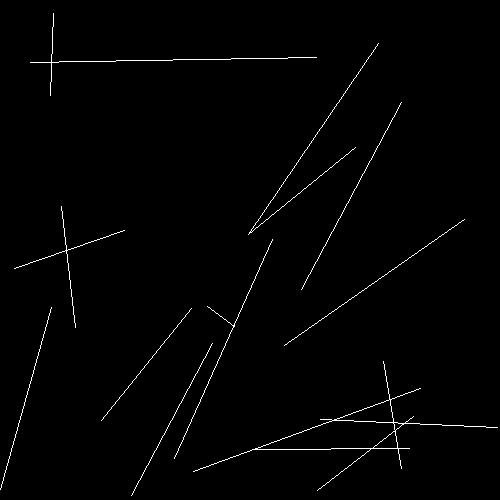

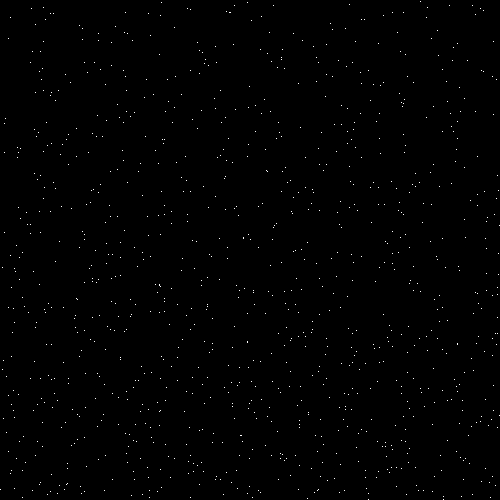

<AxesSubplot: >

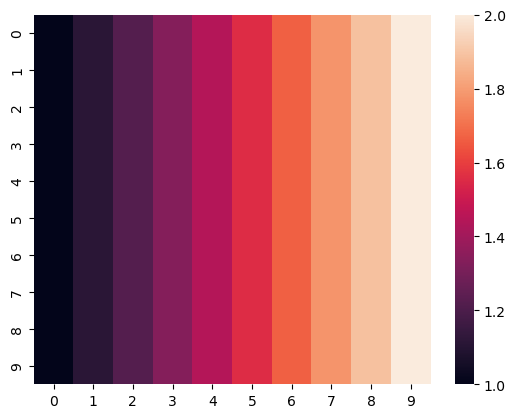

In [13]:
spaghetti, sampling = make_spaghetti(sample, 10, 10)
display(spaghetti)
display(sampling)
sns.heatmap(sampling_intensity)

In [163]:
parents

,individual,parent1,parent2,age,sampling_time,x,y
0,33116,16391,32692,18,40,2.257360,7.95779
1,34603,23871,31567,17,40,9.828050,2.17575
2,34768,27961,31348,17,40,2.658220,5.08471
3,35114,25164,30558,16,40,0.223629,3.71026
4,35559,26638,22147,16,40,9.402830,7.15000
...,...,...,...,...,...,...,...
23682,75461,68296,70176,1,60,1.135510,8.32781
23683,75474,70366,60024,1,60,0.568598,1.34636
23684,75476,63869,71071,1,60,0.523860,3.67937
23685,75492,63462,66153,1,60,6.700600,7.72811


In [165]:
np.zeros(ss.shape)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])